In [68]:
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset
import glob
import pandas as pd
import seawater as sw

dg037_list = glob.glob('/Users/jake/Documents/baroclinic_modes/DG/ABACO_2017/sg037/p*.nc')

# grid parameters  
lat_in = 26.5
lon_in = -76.85
den_grid = np.arange(24.5, 28 , 0.02)
dist_grid = np.arange(20,140,4)
depth_grid = np.arange(0,5000,5)

grid = depth_grid

# output dataframe 
df_t = pd.DataFrame()
df_d = pd.DataFrame()

In [69]:
for i in dg037_list:
    nc_fid = Dataset(i,'r')
    dive_num = nc_fid.dive_number 
    
    if dive_num > 39:                                                # exclude dives carried out getting to transect 
        lat = nc_fid.variables['latitude'][:]
        lon = nc_fid.variables['longitude'][:]
        press = nc_fid.variables['ctd_pressure'][:]
        time = nc_fid.variables['ctd_time'][:]
        temp = nc_fid.variables['temperature'][:]
        salin = nc_fid.variables['salinity'][:]
        pitch_ang = nc_fid.variables['eng_pitchAng'][:]
        
        theta = sw.ptmp(salin, temp, press,0)
        sigma = sw.pden(salin, theta, press) - 1000
        depth = sw.dpth(press,26.5)
        
        # put on distance/density grid (1 column per profile)
        dive_mask = pitch_ang < 0
        climb_mask = pitch_ang > 0 
        
        # toggle interpolation (depth/density)  
        dg_interp = depth      
        temp_grid_dive = np.interp(grid,dg_interp[dive_mask],theta[dive_mask])
        temp_grid_climb = np.interp(grid,np.flipud(dg_interp[climb_mask]),np.flipud(theta[climb_mask]))        
        lon_grid_dive = np.interp(grid,dg_interp[dive_mask],lon[dive_mask])
        lat_grid_dive = np.interp(grid,dg_interp[dive_mask],lat[dive_mask])       
        lon_grid_climb = np.interp(grid,np.flipud(dg_interp[climb_mask]),np.flipud(lon[climb_mask]))
        lat_grid_climb = np.interp(grid,np.flipud(dg_interp[climb_mask]),np.flipud(lat[climb_mask]))
        
        x = (lon_grid_dive - lon_in)*(1852*60*np.cos(np.deg2rad(26.5)))
        y = (lat_grid_dive - lat_in)*(1852*60)
        dist_dive = np.sqrt(x**2 + y**2)/1000
        x = (lon_grid_climb - lon_in)*(1852*60*np.cos(np.deg2rad(26.5)))
        y = (lat_grid_climb - lat_in)*(1852*60)
        dist_climb = np.sqrt(x**2 + y**2)/1000
        
        t_data_d = pd.DataFrame(temp_grid_dive,index=grid,columns=[dive_num])
        t_data_c = pd.DataFrame(temp_grid_climb,index=grid,columns=[dive_num+.5])
        d_data_d = pd.DataFrame(dist_dive,index=grid,columns=[dive_num])
        d_data_c = pd.DataFrame(dist_climb,index=grid,columns=[dive_num+.5])
        
        if df_t.size < 1:
            df_t = pd.concat([t_data_d,t_data_c],axis=1)
            df_d = pd.concat([d_data_d,d_data_c],axis=1)
        else:
            df_t = pd.concat([df_t,t_data_d,t_data_c],axis=1)
            df_d = pd.concat([df_d,d_data_d,d_data_c],axis=1)
        


/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater


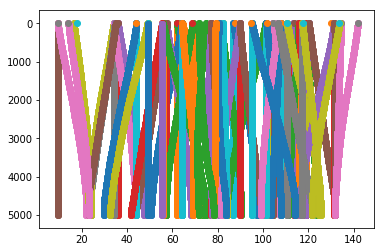

In [71]:
shaper = np.shape(df_d)
for i in range(shaper[1]):
    
    plt.scatter(df_d[df_d.columns[i]],grid)
plt.gca().invert_yaxis()
plt.show()

In [72]:
mean_dist = np.nanmean(df_d,0)
mask = (mean_dist > 20) & (mean_dist < 40)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


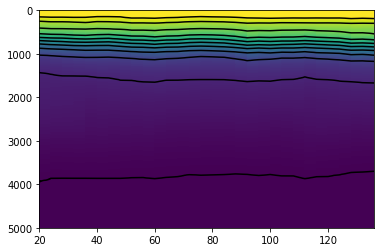

In [74]:
count = 0  
mean_dist = np.nanmean(df_d,0)  
t_grid = np.zeros([np.size(grid),np.size(dist_grid)])  
for i in dist_grid:
    mask = (mean_dist > i-6) & (mean_dist < i+6)
    t_grid[:,count] = np.nanmean(df_t[df_t.columns[mask]],1)        
    count = count + 1
    
plt.pcolor(dist_grid,grid,t_grid, vmin=2, vmax=22)  
pc = plt.contour(dist_grid,grid,t_grid,colors='k',levels=np.arange(2,24,2))
plt.gca().invert_yaxis()
plt.show()